In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
np.random.seed(8)

In [4]:
import os
import glob
from contextlib import suppress
import warnings
from zipfile import ZipFile
from skimage.io import imread, imsave

# source_dir="drive/My Drive/UCMerced_LandUse/Images/"
# # creating the list of class names
# class_names=os.listdir('drive/My Drive/UCMerced_LandUse/Images/')
# # Create path to image "flow" base directory
# flow_base = os.path.join('drive', 'My Drive', 'flow')
# # Create pathnames to train/validate/test subdirectories
# target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

# if not os.path.isdir(flow_base):

#     # Make new directories
#     os.mkdir(flow_base)
    
#     for target in ['train', 'validate', 'test']:
#         target_dir = os.path.join(flow_base, target)
#         os.mkdir(target_dir)
#         for class_name in class_names:
#             class_subdir = os.path.join(target_dir, class_name)
#             os.mkdir(class_subdir)

#     # suppress low-contrast warning from skimage.io.imsave
#     warnings.simplefilter('ignore', UserWarning)
    
#     # Copy images from ./drive/My Drive/UCMerced_LandUse/Images to ./drive/My Drive/flow/<train, validate, test>    
#     for root, _, filenames in os.walk(source_dir):
#         if filenames:
#             class_name = os.path.basename(root)

#             # Randomly shuffle filenames
#             filenames = np.random.permutation(filenames)
#             for target, count in [('train', 70), ('validate', 10), ('test', 20)]:
#                 target_dir = os.path.join(flow_base, target, class_name)
#                 for filename in filenames[:count]:
#                     filepath = os.path.join(root, filename)
#                     image = imread(filepath)
#                     basename, _ = os.path.splitext(filename)
#                     # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
#                     target_filename = os.path.join(target_dir, basename + '.png')
#                     imsave(target_filename, image)
            
#                 filenames = filenames[count:]
    
#     # Show future warnings during development
#     warnings.resetwarnings()

In [5]:
flow_base = os.path.join('drive', 'My Drive', 'flow')
# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

In [6]:
# means = []
# stds=[]

# for root, _, filenames in os.walk(target_dirs['train']):
#     for filename in filenames:
#         filepath = os.path.join(root, filename)
#         image = imread(filepath)
#         means.append(np.mean(image, axis=(0, 1)))
#         stds.append(np.nanstd(image,axis=(0,1)))
# channel_means = np.mean(means, axis=0)
# channel_stds=np.mean(stds,axis=0)
# channel_means/=255.0
# channel_stds/=255.0

# print(channel_means)
# print(channel_stds)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([123.42, 124.95, 115.01], [44.12, 41.57, 39.52])
    ]),
    'validate': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([123.42, 124.95, 115.01], [44.12, 41.57, 39.52])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([123.42, 124.95, 115.01], [44.12, 41.57, 39.52])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(flow_base, x),
                                          data_transforms[x])
                  for x in ['train', 'validate','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validate','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validate','test']}
class_names = image_datasets['train'].classes
print(len(class_names))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

21


In [8]:
import copy
import time
def train_model(model, criterion, optimizer,  num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # print("input ", inputs[0])
                # print("labels ",len(labels))
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
                # scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validate' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
import torchvision.models as models
import torch.optim as optim

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.add_module("dropout", nn.Dropout(p=0.6))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=50)


Epoch 0/49
----------
train Loss: 1.8007 Acc: 0.5184
validate Loss: 3.5366 Acc: 0.0667

Epoch 1/49
----------
train Loss: 0.5562 Acc: 0.8864
validate Loss: 3.5143 Acc: 0.1238

Epoch 2/49
----------
train Loss: 0.2417 Acc: 0.9469
validate Loss: 3.5642 Acc: 0.1000

Epoch 3/49
----------
train Loss: 0.1106 Acc: 0.9864
validate Loss: 2.3017 Acc: 0.3905

Epoch 4/49
----------
train Loss: 0.0562 Acc: 0.9959
validate Loss: 3.0800 Acc: 0.1286

Epoch 5/49
----------
train Loss: 0.0277 Acc: 1.0000
validate Loss: 3.1687 Acc: 0.2524

Epoch 6/49
----------
train Loss: 0.0351 Acc: 0.9952
validate Loss: 3.6227 Acc: 0.1000

Epoch 7/49
----------
train Loss: 0.0274 Acc: 0.9973
validate Loss: 2.1712 Acc: 0.4762

Epoch 8/49
----------
train Loss: 0.0255 Acc: 0.9952
validate Loss: 2.9593 Acc: 0.1667

Epoch 9/49
----------
train Loss: 0.0298 Acc: 0.9932
validate Loss: 4.0628 Acc: 0.1667

Epoch 10/49
----------
train Loss: 0.0238 Acc: 0.9973
validate Loss: 2.2396 Acc: 0.4667

Epoch 11/49
----------
train Lo

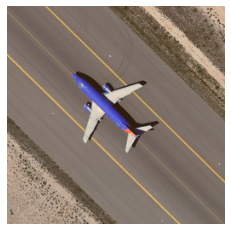

In [11]:
plt.imshow(imread('drive/My Drive/flow/train/airplane/airplane78.png'))
plt.axis('off')
plt.show()

In [12]:
# torch.save(model_ft, 'drive/My Drive/cnn_ucmerced_models/model_94acc.model')

In [13]:
m = torch.load('drive/My Drive/cnn_ucmerced_models/model_94acc.model',map_location='cpu')
m.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for inputs,labels in dataloaders['test']:
        # inputs=inputs.to(device)
        # labels=labels.to(device)
        outputs = m(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc=correct/total
acc=round(acc,3)
print('Accuracy of the network on the',total,'test images with',correct,'correct images :',acc*100,'%')

Accuracy of the network on the 420 test images with 396 correct images : 94.3 %


In [16]:
from sklearn.metrics import confusion_matrix

nb_classes = 21

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        # inputs = inputs.to(device)
        # classes = classes.to(device)
        outputs = m(inputs)
        _, preds = torch.max(outputs, 1)
        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
a=image_datasets['test'].classes
# print(class_accuracy)
class_wise_accuracy={}
for i,j in zip(a,class_accuracy):
  class_wise_accuracy[i]=j
class_wise_accuracy

[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0 19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 18  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  1  0  0  0  0 12  0  0  0  0  1  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 19  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0

{'agricultural': 100.0,
 'airplane': 100.0,
 'baseballdiamond': 100.0,
 'beach': 100.0,
 'buildings': 95.0,
 'chaparral': 100.0,
 'denseresidential': 85.0,
 'forest': 85.0,
 'freeway': 100.0,
 'golfcourse': 95.0,
 'harbor': 100.0,
 'intersection': 90.0,
 'mediumresidential': 60.0,
 'mobilehomepark': 95.0,
 'overpass': 100.0,
 'parkinglot': 100.0,
 'river': 95.0,
 'runway': 90.0,
 'sparseresidential': 90.0,
 'storagetanks': 100.0,
 'tenniscourt': 100.0}